In [2]:
# -*- coding: utf-8 -*-
"""
Created on Fri Sep 27 01:35:26 2024

@author: Yunus
"""



'\nCreated on Fri Sep 27 01:35:26 2024\n\n@author: Yunus\n'

In [22]:
# pip install cvxopt

In [24]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from cvxopt import matrix, solvers

In [26]:
# List of stock symbols
stocks = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA']

# Download historical data for the last year
data = yf.download(stocks, start="2023-01-01", end="2024-01-01")['Adj Close']

# Calculate daily returns
returns = data.pct_change().dropna()

mean_returns = returns.mean()
cov_matrix = returns.cov()

# Show the first few rows of the returns
returns.head()


[*********************100%%**********************]  5 of 5 completed


Ticker,AAPL,AMZN,GOOGL,MSFT,TSLA
Date,,,,,
2023-01-04,0.010314,-0.007924,-0.011670,-0.043743,0.051249
2023-01-05,-0.010605,-0.023726,-0.021344,-0.029638,-0.029039
2023-01-06,0.036794,0.035611,0.013225,0.011785,0.024651
2023-01-09,0.004089,0.014870,0.007786,0.009736,0.059349
2023-01-10,0.004456,0.028732,0.004544,0.007617,-0.007681


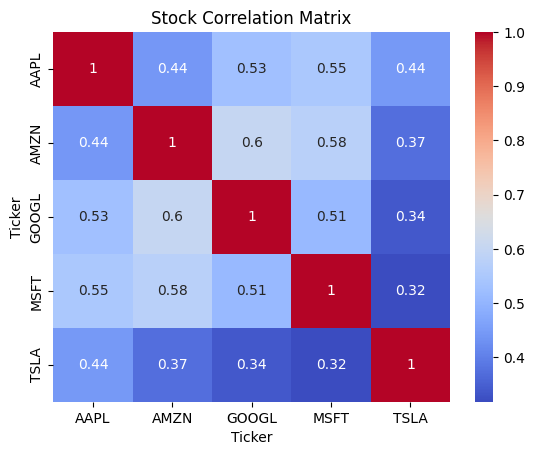

In [6]:
# Calculate the correlation matrix
correlation_matrix = returns.corr()

# Display the correlation matrix as a heatmap
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Stock Correlation Matrix")
plt.show()


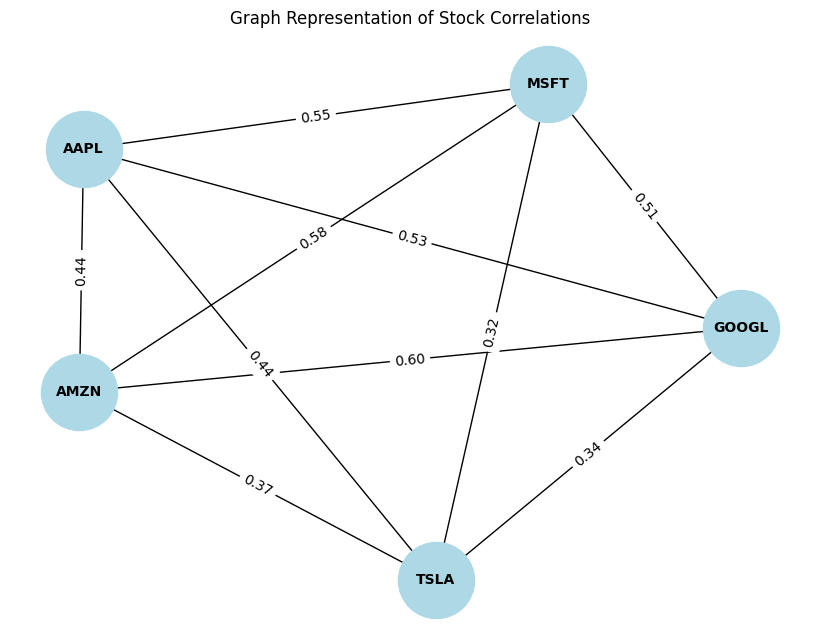

In [8]:
import networkx as nx

# Create an empty graph
G = nx.Graph()

# Add nodes (stocks)
G.add_nodes_from(correlation_matrix.columns)

# Add edges with weights based on correlations
for i, stock1 in enumerate(correlation_matrix.columns):
    for j, stock2 in enumerate(correlation_matrix.columns):
        if i != j:
            G.add_edge(stock1, stock2, weight=abs(correlation_matrix.iloc[i, j]))

# Visualize the graph
plt.figure(figsize=(8, 6))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=3000, font_size=10, font_weight='bold')

# Draw edge labels to show correlation weights
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels={k: f"{v:.2f}" for k, v in edge_labels.items()})

plt.title("Graph Representation of Stock Correlations")
plt.show()


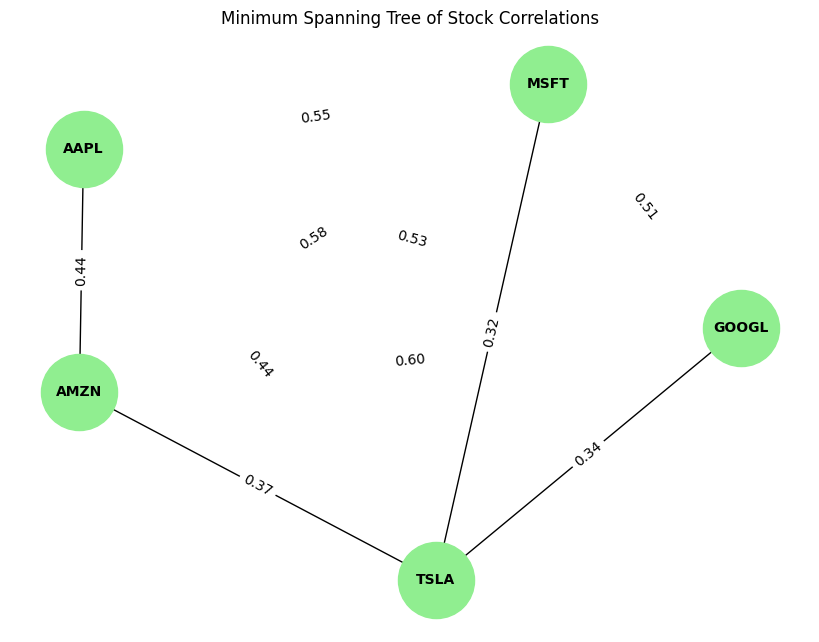

In [10]:
# Create the Minimum Spanning Tree
mst = nx.minimum_spanning_tree(G, weight='weight')

# Visualize the MST
plt.figure(figsize=(8, 6))
nx.draw(mst, pos, with_labels=True, node_color='lightgreen', node_size=3000, font_size=10, font_weight='bold')
nx.draw_networkx_edge_labels(mst, pos, edge_labels={k: f"{v:.2f}" for k, v in edge_labels.items()})

plt.title("Minimum Spanning Tree of Stock Correlations")
plt.show()


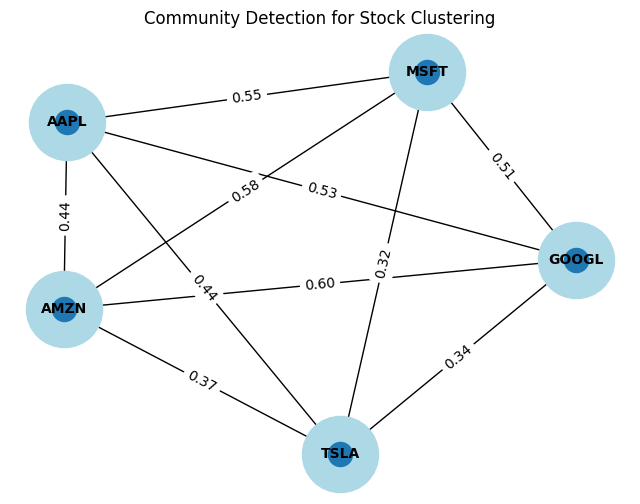

In [12]:
from networkx.algorithms.community import greedy_modularity_communities

# Apply community detection to find clusters of stocks
communities = list(greedy_modularity_communities(G))

# Visualize the detected communities
colors = ['lightblue', 'lightgreen', 'lightcoral', 'lightgoldenrodyellow', 'lightpink']
plt.figure(figsize=(8, 6))

for i, community in enumerate(communities):
    nx.draw_networkx_nodes(G, pos, nodelist=community, node_color=colors[i % len(colors)], node_size=3000)
nx.draw(G, pos, with_labels=True, font_size=10, font_weight='bold')
nx.draw_networkx_edge_labels(G, pos, edge_labels={k: f"{v:.2f}" for k, v in edge_labels.items()})

plt.title("Community Detection for Stock Clustering")
plt.show()


In [14]:
# Calculate betweenness centrality for each stock
bet_centrality = nx.betweenness_centrality(G, weight='weight')

# Sort stocks by their betweenness centrality
sorted_bet_centrality = sorted(bet_centrality.items(), key=lambda x: x[1], reverse=True)

# Display the stocks with the highest betweenness centrality
print("Top Stocks by Betweenness Centrality:")
for stock, centrality in sorted_bet_centrality:
    print(f"{stock}: {centrality:.4f}")


Top Stocks by Betweenness Centrality:
AAPL: 0.0000
AMZN: 0.0000
GOOGL: 0.0000
MSFT: 0.0000
TSLA: 0.0000


In [28]:
def markowitz_optimization(mean_returns, cov_matrix, target_return):
    n = len(mean_returns)  # Number of assets
    P = matrix(np.array(cov_matrix))  # Covariance matrix (quadratic objective term)
    q = matrix(np.zeros((n, 1)))  # Linear objective term (zero because we minimize variance)
    
    # Constraints
    G = matrix(np.vstack((-np.array(mean_returns), -np.eye(n))))  # Return constraint and non-negativity
    h = matrix(np.hstack((-target_return, np.zeros(n))))  # Target return and no short-selling constraint
    
    # The equality constraint (sum of weights equals 1)
    A = matrix(1.0, (1, n))
    b = matrix(1.0)

    # Solve quadratic programming problem
    sol = solvers.qp(P, q, G, h, A, b)
    return np.array(sol['x']).flatten()

# Set a target return (for example, 0.001 as daily expected return)
target_return = 0.001
optimal_weights = markowitz_optimization(mean_returns, cov_matrix, target_return)

# Display the optimal weights
print("Optimal Portfolio Weights:")
for stock, weight in zip(stocks, optimal_weights):
    print(f"{stock}: {weight:.4f}")


     pcost       dcost       gap    pres   dres
 0:  1.1649e-04 -1.0017e+00  1e+00  1e-19  3e+00
 1:  1.1647e-04 -9.9950e-03  1e-02  2e-16  3e-02
 2:  1.1514e-04 -7.6792e-05  2e-04  1e-16  5e-04
 3:  8.9924e-05  4.7261e-05  4e-05  1e-16  8e-05
 4:  7.4977e-05  6.6787e-05  8e-06  5e-17  8e-20
 5:  7.2701e-05  7.1866e-05  8e-07  2e-17  3e-20
 6:  7.2372e-05  7.2328e-05  4e-08  2e-16  4e-20
Optimal solution found.
Optimal Portfolio Weights:
AAPL: 0.7112
MSFT: 0.0276
GOOGL: 0.0359
AMZN: 0.2251
TSLA: 0.0002


In [30]:
# Calculate expected portfolio return and risk
expected_return = np.dot(optimal_weights, mean_returns)
portfolio_variance = np.dot(optimal_weights.T, np.dot(cov_matrix, optimal_weights))
portfolio_std_dev = np.sqrt(portfolio_variance)  # Portfolio risk (volatility)

print(f"\nExpected Portfolio Return: {expected_return:.4f}")
print(f"Portfolio Risk (Standard Deviation): {portfolio_std_dev:.4f}")



Expected Portfolio Return: 0.0019
Portfolio Risk (Standard Deviation): 0.0120


     pcost       dcost       gap    pres   dres
 0:  1.1648e-04 -1.0023e+00  1e+00  1e-16  3e+00
 1:  1.1647e-04 -1.0001e-02  1e-02  4e-17  3e-02
 2:  1.1514e-04 -7.6914e-05  2e-04  9e-17  5e-04
 3:  8.9912e-05  4.7129e-05  4e-05  7e-17  8e-05
 4:  7.4967e-05  6.6748e-05  8e-06  2e-16  6e-20
 5:  7.2702e-05  7.1866e-05  8e-07  2e-16  7e-20
 6:  7.2372e-05  7.2328e-05  4e-08  2e-16  5e-20
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  1.1648e-04 -1.0023e+00  1e+00  0e+00  3e+00
 1:  1.1647e-04 -1.0001e-02  1e-02  6e-17  3e-02
 2:  1.1514e-04 -7.6910e-05  2e-04  6e-17  5e-04
 3:  8.9912e-05  4.7132e-05  4e-05  1e-16  8e-05
 4:  7.4967e-05  6.6749e-05  8e-06  2e-17  5e-20
 5:  7.2702e-05  7.1866e-05  8e-07  1e-16  4e-20
 6:  7.2372e-05  7.2328e-05  4e-08  1e-16  4e-20
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  1.1648e-04 -1.0023e+00  1e+00  2e-16  3e+00
 1:  1.1647e-04 -1.0001e-02  1e-02  1e-16  3e-02
 2:  1.1514e-04 -7.6907e

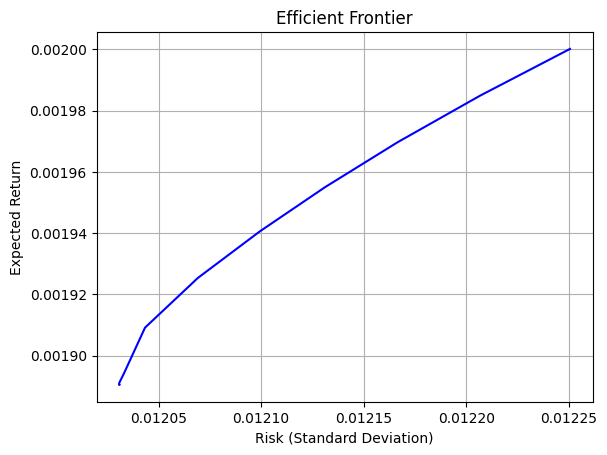

In [34]:
def efficient_frontier(mean_returns, cov_matrix, num_points=100):
    target_returns = np.linspace(0.0005, 0.002, num_points)
    risks = []
    returns = []
    
    for target in target_returns:
        weights = markowitz_optimization(mean_returns, cov_matrix, target)
        portfolio_return = np.dot(weights, mean_returns)
        portfolio_risk = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        risks.append(portfolio_risk)
        returns.append(portfolio_return)
    
    return risks, returns

# Generate the efficient frontier
risks, returns = efficient_frontier(mean_returns, cov_matrix)

# Plot the efficient frontier
plt.plot(risks, returns, label='Efficient Frontier', color='blue')
plt.xlabel('Risk (Standard Deviation)')
plt.ylabel('Expected Return')
plt.title('Efficient Frontier')
plt.grid(True)
plt.show()


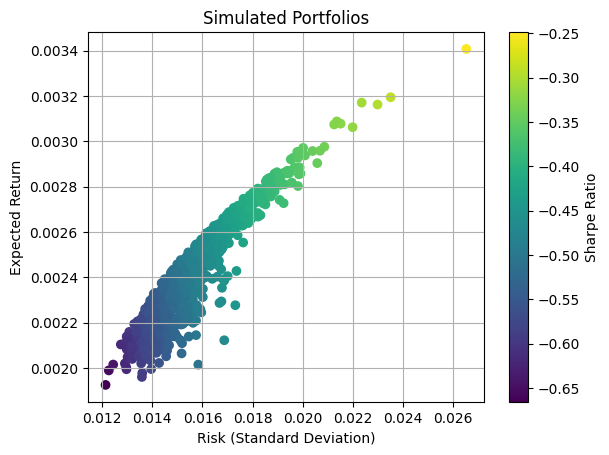

In [36]:
def simulate_random_portfolios(mean_returns, cov_matrix, num_portfolios=1000):
    results = np.zeros((num_portfolios, 3))
    for i in range(num_portfolios):
        # Generate random portfolio weights
        weights = np.random.random(len(mean_returns))
        weights /= np.sum(weights)
        
        # Calculate portfolio return and risk
        portfolio_return = np.dot(weights, mean_returns)
        portfolio_risk = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_risk
        
        results[i] = [portfolio_return, portfolio_risk, sharpe_ratio]
    
    return results

# Simulate portfolios
portfolios = simulate_random_portfolios(mean_returns, cov_matrix)

# Plot simulated portfolios
plt.scatter(portfolios[:, 1], portfolios[:, 0], c=portfolios[:, 2], cmap='viridis', marker='o')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Risk (Standard Deviation)')
plt.ylabel('Expected Return')
plt.title('Simulated Portfolios')
plt.grid(True)
plt.show()
